In [114]:
import xarray as xr 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
import scipy.stats as ss
import copy
from scipy.stats import gaussian_kde

### Quantile mapping for climate data

This script contains code to perform quantile mapping from MERRA-2 data to in-situ observations from a weather station. Lines you should edit are marked with a *

In [115]:
# ========= WEATHER STATION INFO =========
# Station location
glacier = 'wolverine'                 # * Glacier name consistent with AWS data 
lat = 60.394864                          # * Station latitude [decimal degrees]
lon = -148.945242                      # * Station ongitude [decimal degrees]
elev_AWS = 1420                     # * Station elevation [m a.s.l.]
timezone = pd.Timedelta(hours=-8)   # * Station local time zone compared to UTC

# MERRA-2 INFO
start_MERRA2_data = pd.to_datetime('1980-01-01 00:00')  # First timestamp in MERRA-2 data
end_MERRA2_data = pd.to_datetime('2025-06-30 00:00')    # Last timestamp in MERRA-2 data
MERRA2_filetag = glacier+'_alltime.nc'                  # * False to use lat/lon indexed files, otherwise string to follow 'MERRA2_VAR_'

# ========= FILEPATHS =========
fp_base = os.getcwd() + '/../../../'    # Base filepath to direct files to
# MERRA-2
fp_MERRA = fp_base + 'climate_data/MERRA2/'             # Filepath to MERRA-2 data
fn_MERRA = fp_MERRA + 'VAR/MERRA2_VAR_LAT_LON.nc'       # Formattable file name for MERRA-2 variable data
# AWS
fp_AWS = fp_base + 'climate_data/AWS/'        # Filepath to processed AWS data
fn_AWS = fp_AWS + 'Raw/Benchmark/wolverine/LVL2/wolverine1420_hourly_LVL2.csv'          # * Filename of AWS data to use in mapping
assert os.path.exists(fn_AWS), f'AWS dataset not found at {fn_AWS}'
# OUTPUT
fn_store_quantiles = fp_base + f'PEBSI/data/bias_adjustment/quantile_mapping_{glacier}_VAR.csv'     # Filename to store quantiles
fn_store_fig = fp_base + 'Output/all_quantile_mapping.png'                                          # Filename to store figures

# Get MERRA-2 elevation (gepotential)
flat = str(int(np.floor(lat/10)*10))        # Latitude rounded to 10 degrees to find the right file
flon = str(int(np.floor(lon/10)*10))        # Longitude rounded to 10 degrees to find the right file
elev_MERRA2 = xr.open_dataarray(fp_MERRA + 'MERRA2constants.nc4').sel(lat=flat,lon=flon).values[0] / 9.81

# Update MERRA-2 filepath
if not MERRA2_filetag:
    fn_MERRA = fn_MERRA.replace('LAT', str(flat)).replace('LON', str(flon))
else:
    fn_MERRA = fn_MERRA.replace('LAT_LON.nc', MERRA2_filetag)

### Functions

The two functions below perform quantile mapping and plot it so you can visually inspect.

In [116]:
def quantile_mapping(data_AWS,data_MERRA,var=None):
    # Sort MERRA data and align AWS data accordingly
    sorted_indices = np.argsort(data_MERRA)
    data_MERRA_sorted = data_MERRA[sorted_indices]
    data_AWS_sorted = data_AWS[sorted_indices]

    # Compute empirical CDF
    reanalysis_cdf = (ss.rankdata(data_MERRA_sorted, method="average") - 1) / (len(data_MERRA_sorted) - 1)

    # Map MERRA quantiles to AWS quantiles
    quantile_map = np.interp(reanalysis_cdf, np.sort(reanalysis_cdf), np.sort(data_AWS_sorted))

    # Store data if executed with a var
    if var is not None:
        fn = fn_store_quantiles.replace('VAR',var)
        df = pd.DataFrame({'sorted': data_MERRA_sorted, 'mapping': quantile_map})
        print('stored to', fn)
        df.to_csv(fn)

    return data_MERRA_sorted, quantile_map

def plot_scatter(X_train, y_train, lims, var=None, plot_kde=False, plot_axes=None):
    """
    Creates a scatter plot with a 1:1 line 
    to view the difference between uncorrected
    and corrected MERRA-2 data.

    Parameters:
    X_train : np.array
        Array containing the AWS training data
    y_train : np.array 
        Array containing the MERRA-2 training data
    lims : tuple
        List or tuple of the plot y and x axis limits
    var : str
        Optional: the variable name being corrected
    plot_kde : Bool
        Optional: plot the density of points
        ! Takes much longer to execute this code
    plot_axes : plt.ax object
        Axis to plot on; otherwise a new ax is generated
    """
    if var is not None:
        df = pd.read_csv(fn_store_quantiles.replace('VAR',var))
        sorted = df['sorted'].values
        mapping = df['mapping'].values
    else:
        # Train quantile map
        sorted, mapping = quantile_mapping(X_train, y_train)

    # Plot it
    if plot_axes is None:
        fig,(ax1,ax2) = plt.subplots(1,2,figsize=(6,2.75),gridspec_kw={'wspace':0.3,'hspace':0.3})
    else:
        (ax1,ax2) = plot_axes

    # Raw scatter
    if plot_kde:
        kde = gaussian_kde([X_train, y_train])
        density = kde(np.vstack([X_train, y_train]))
        ax1.scatter(X_train, y_train, s=3, c=density, cmap=plt.cm.magma)
    else:
        ax1.scatter(X_train, y_train, s=2, c='gray')
    ax1.plot(lims,lims,'k--',label='1:1')
    ax1.legend()
    ax1.set_xlabel('AWS',fontsize=11)
    ax1.set_ylabel('MERRA-2',fontsize=11)
    ax1.set_title('Raw data')

    # Updated scatter
    updated = np.interp(y_train, sorted, mapping)
    if plot_kde:
        kde = gaussian_kde([X_train, updated])
        density = kde(np.vstack([X_train, updated]))
        ax2.scatter(X_train, updated, s=3, c=density, cmap=plt.cm.magma)
    else:
        ax2.scatter(X_train, updated, s=2, c='gray')
    ax2.plot(lims,lims,'k--',label='1:1')
    ax2.set_xlabel('AWS',fontsize=11)
    ax2.set_title('Adjusted data')

    # All axes
    for ax in [ax1,ax2]:
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.tick_params(length=5)

    if plot_axes is None:
        return fig, (ax1,ax2)
    else:
        return ax1,ax2
    
def plot_quantile(X_train, y_train, y_all, timed, 
                  var=None, plot_axes=None, legend=True):
    """
    Creates a two panel plot showing A) the density distribution
    before and after correction of MERRA-2 data and the 
    distribution of AWS data as a histogram and B) a selected
    time range of data for all three datasets.

    Parameters:
    X_train : np.array
        Array containing the AWS training data
    y_train : np.array 
        Array containing the MERRA-2 training data
    y_all : np.array
        Array containing ALL MERRA-2 data for this variable
    timed : tuple
        List of clipped arrays containing:
        0: time (pd.date_range-type object)
        1: original MERRA-2 data clipped to time
        2: updated MERRA-2 data clipped to time
        3: AWS data clipped to time 
    var : str
        Optional: the variable name being corrected
    plot_axes : plt.ax object
        Axis to plot on; otherwise a new ax is generated
    legend : Bool
        Add legend to figure or not
    """
    if var is not None:
        df = pd.read_csv(fn_store_quantiles.replace('VAR',var))
        sorted = df['sorted'].values
        mapping = df['mapping'].values
    else:
        # Train quantile map
        sorted, mapping = quantile_mapping(X_train, y_train)

    # Plot it
    if plot_axes is None:
        fig,(ax1,ax2) = plt.subplots(1,2,figsize=(6,2.75),gridspec_kw={'wspace':0.4})
    else:
        (ax1,ax2) = plot_axes

    # Colors
    c1,c2,c3,_,_, = ['#63c4c7','#fcc02e','#4D559C','#BF1F6A','#60C252']
    
    # Distributions
    updated_all = np.interp(y_all, sorted, mapping)
    _,hist_bins = np.histogram(X_train)
    ax1.hist(y_all,bins=hist_bins,histtype='step',orientation='horizontal',label='Original MERRA-2',linestyle='--',density=True,color=c1,linewidth=1.5)
    ax1.hist(updated_all,bins=hist_bins,histtype='step',orientation='horizontal',label='Corrected MERRA-2',density=True,color=c2,linewidth=1.5)
    ax1.hist(X_train,bins=hist_bins,histtype='step',orientation='horizontal',label='Weather station',density=True,color=c3,linewidth=1.5)
    ax1.set_ylabel('Probability density', fontsize=12)

    # Timeseries
    time, raw, adj, aws = timed
    time += timezone # put into local time
    ax2.plot(time, raw, linestyle='--',label='Original MERRA-2',color=c1)
    ax2.plot(time, adj, label='Corrected MERRA-2',color=c2)
    ax2.plot(time, aws,label='Weather station',color=c3)
    ax2.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))
    ax2.set_xticks(time[::12])
    ax2.set_xlim(time[0],time[-1])

    if legend:
        # Add fake axis
        ax3 = fig.add_axes([1.05,0.1,0.1,0.8])
        ax3.axis('off')
        ax3.plot(np.nan, np.nan,linestyle='--',label='Original MERRA-2',color=c1)
        ax3.plot(np.nan, np.nan,label='Corrected MERRA-2',color=c2)
        ax3.plot(np.nan, np.nan,label='Weather station',color=c3)
        ax3.legend(loc='center')

    # All axes
    for ax in [ax1,ax2]:
        ax.tick_params(length=5)

    if plot_axes is None:
        return fig, (ax1,ax2)
    else:
        return ax1,ax2
    
def select_random_48hr_window(df):
    # Ensure timestamps are sorted
    df = df.sort_index()
    df = df.reindex(pd.date_range(df.index[0], df.index[-1], freq='h'))

    window_size = 48

    # Slide through the DataFrame
    for i in range(len(df) - window_size + 1):
        window = df.iloc[i:i + window_size]
        if not window.isnull().any().any():
            return window.index

### Load and clean the data

You likely need to make minor edits to this code to ensure the data is loaded properly and you are comparing what you want to compare. For example, if you are using temperature, you will need to specify a temperature lapse rate. Otherwise, comment those lines.

In [117]:
# ======== LOAD DATA ========
# Define name of variable as it apperas in MERRA-2 data and in the AWS data
var = 'SWin'                # Name of var as referenced in PEBSI
var_MERRA2 = 'SWGDN'        # Name of var in the MERRA-2 data
var_AWS = 'RadiationIn'     # Name of var in the AWS data
var_label = 'Incoming shortwave (W m-2)' # 'Wind speed (m/s)' # 'Air temperature ($^{\circ}$C)'

# Open datasets
data_MERRA2 = xr.open_dataarray(fn_MERRA.replace('VAR',var_MERRA2))
data_AWS = pd.read_csv(fn_AWS, index_col=0)[var_AWS]

# Wind is treated differently since it is broken into east and west components by MERRA-2
both_wind = ['U2M','V2M']
if var_MERRA2 in both_wind:
    both_wind.remove(var_MERRA2)
    other_variable = both_wind[0]
    data_MERRA2_other = xr.open_dataarray(fn_MERRA.replace('VAR',other_variable))
    data_MERRA2.values = np.sqrt(data_MERRA2.values**2 + data_MERRA2_other.values**2)

# Clip MERRA-2 dataset to the right lat/lon
if not MERRA2_filetag:
    data_MERRA2 = data_MERRA2.sel(lat=lat,lon=lon, method='nearest')
else:
    data_MERRA2 = data_MERRA2

# ======== ELEVATION DEPENDENCE ========
# Temperature should first be adjusted to the same elevation
# lapse_rate = -6.5           # Lapse rate [K km-1]
# data_MERRA2 += (elev_AWS - elev_MERRA2) * lapse_rate / 1000

# ======== CHECK VALUES ========
# Update units to match the AWS
# data_MERRA2 -= 273.15
data_MERRA2 *= 3600
data_AWS *= 3600

# Check for unreasonable values
upper_lim =4e6
lower_lim = 0
data_AWS = data_AWS[(data_AWS.values >= lower_lim) & (data_AWS.values <= upper_lim)]

Clip the datasets to the time periods where the AWS has data.

In [118]:
# ======== TIME ========
# Define all_MERRA2 variable
all_MERRA2 = data_MERRA2.values

# Make sure AWS data is using datetime index
data_AWS.index = pd.to_datetime(data_AWS.index)

# If AWS data is in local time, convert to UTC
data_AWS.index -= pd.Timedelta(hours=-9) #  timezone
print('ASSUMING AWS DATA IS IN LOCAL TIME: COMMENT THIS SECTION IF IT IS IN UTC')

# Find dates where AWS recorded temperature
dates_data = data_AWS.index[~np.isnan(data_AWS)]

# Filter out dates that are outside of MERRA-2 range
dates_data = dates_data[dates_data >= start_MERRA2_data]
dates_data = dates_data[dates_data <= end_MERRA2_data]

# Make sure there are not repeated values
dates_data = np.unique(dates_data)

# Select dates where AWS has data
data_MERRA2 = data_MERRA2.interp(time=pd.to_datetime(dates_data))
data_AWS = data_AWS.loc[dates_data]

ASSUMING AWS DATA IS IN LOCAL TIME: COMMENT THIS SECTION IF IT IS IN UTC


Perform quantile mapping and generate plots to inspect the results. It is crucial to inspect the plot of the updated distribution of all MERRA-2 data to ensure the distribution matches the AWS distribution better than the original MERRA-2 data. 

For example, If your AWS only operates over the summer, correcting year-round temperature or shortwave data will skew results, as the distribution of values is very different winter to summer. 

stored to c:\Users\cvw30\Research\Model\PEBSI\pebsi\preprocessing/../../../PEBSI/data/bias_adjustment/quantile_mapping_wolverine_SWin.csv


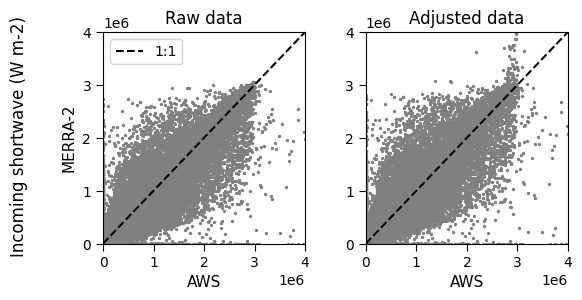

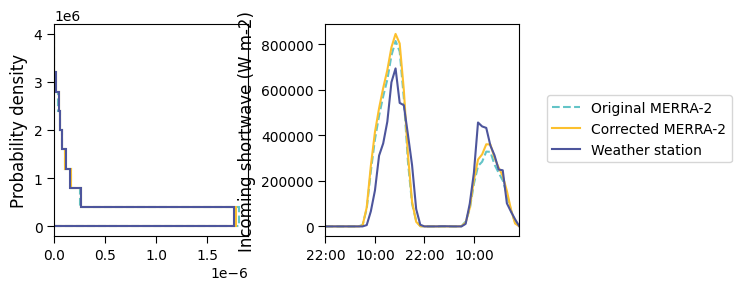

In [119]:
# ======== WHICH PLOTS ========
get_scatter_plot = True
get_quantile_plot = True

# Separate data into train and test
X_train = data_AWS.values
y_train = data_MERRA2.values

# Get quantile mapping and store it
sorted, mapping = quantile_mapping(X_train, y_train, var)

# Plot scatter plot
if get_scatter_plot:
    plot_lims = [0,4e6]
    fig, axes = plot_scatter(X_train, y_train, lims=plot_lims, plot_kde=False)
    fig.supylabel(var_label,x=-0.03)
    plt.show()

# Select time range for plot_quantile subplot
time = select_random_48hr_window(data_AWS)

# Create the timed variable for quantile function
raw = data_MERRA2.sel(time=time)
adj = np.interp(raw, sorted, mapping)
aws = data_AWS.loc[time]

# Plot quantiles
if get_quantile_plot:
    fig, axes = plot_quantile(X_train, y_train, all_MERRA2, timed = (time, raw, adj, aws))
    axes[-1].set_ylabel(var_label,fontsize=12)
    plt.savefig(fn_store_fig,dpi=200,bbox_inches='tight')
    plt.show()

## Inspect metrics before and after

The goal of quantile mapping is to remove bias, so after performing this correction you should see the bias decrease. MAE and RMSE may increase, and if they do substantially you may want to inspect your plots and make sure the timing matches up.

In [102]:
MAE_before = np.mean(np.abs(y_train - X_train))
ME_before = np.mean(y_train - X_train)
RMSE_before = np.sqrt(np.mean(np.square(y_train - X_train)))
y_adj = np.interp(y_train, sorted, mapping)
MAE_after = np.mean(np.abs(y_adj - X_train))
ME_after = np.mean(y_adj - X_train)
RMSE_after = np.sqrt(np.mean(np.square(y_adj - X_train)))

all = np.array([MAE_before, MAE_after, RMSE_before, RMSE_after, ME_before, ME_after])
df = pd.DataFrame(all, index=['MAE original','MAE bias-corrected','RMSE original', 'RMSE bias-corrected','ME original','ME bias-corrected'],columns=['Temperature'])
df

,Temperature
MAE original,38.798159
MAE bias-corrected,39.405222
RMSE original,83.745817
RMSE bias-corrected,85.319677
ME original,-5.763402
ME bias-corrected,0.008549


In [11]:
# DONE